In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import theano
import theano.tensor as tt
from scipy import stats

In [7]:
!curl https://raw.githubusercontent.com/facebook/prophet/master/examples/example_wp_log_peyton_manning.csv > data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 86845  100 86845    0     0   700k      0 --:--:-- --:--:-- --:--:--  700k


In [2]:
df = pd.read_csv('data.csv')
df['ds'] = pd.to_datetime(df['ds'])
df['y_scaled'] = df['y'] / df['y'].max()
df['t'] = (df['ds'] - df['ds'].min()) / (df['ds'].max() - df['ds'].min())


/opt/miniconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


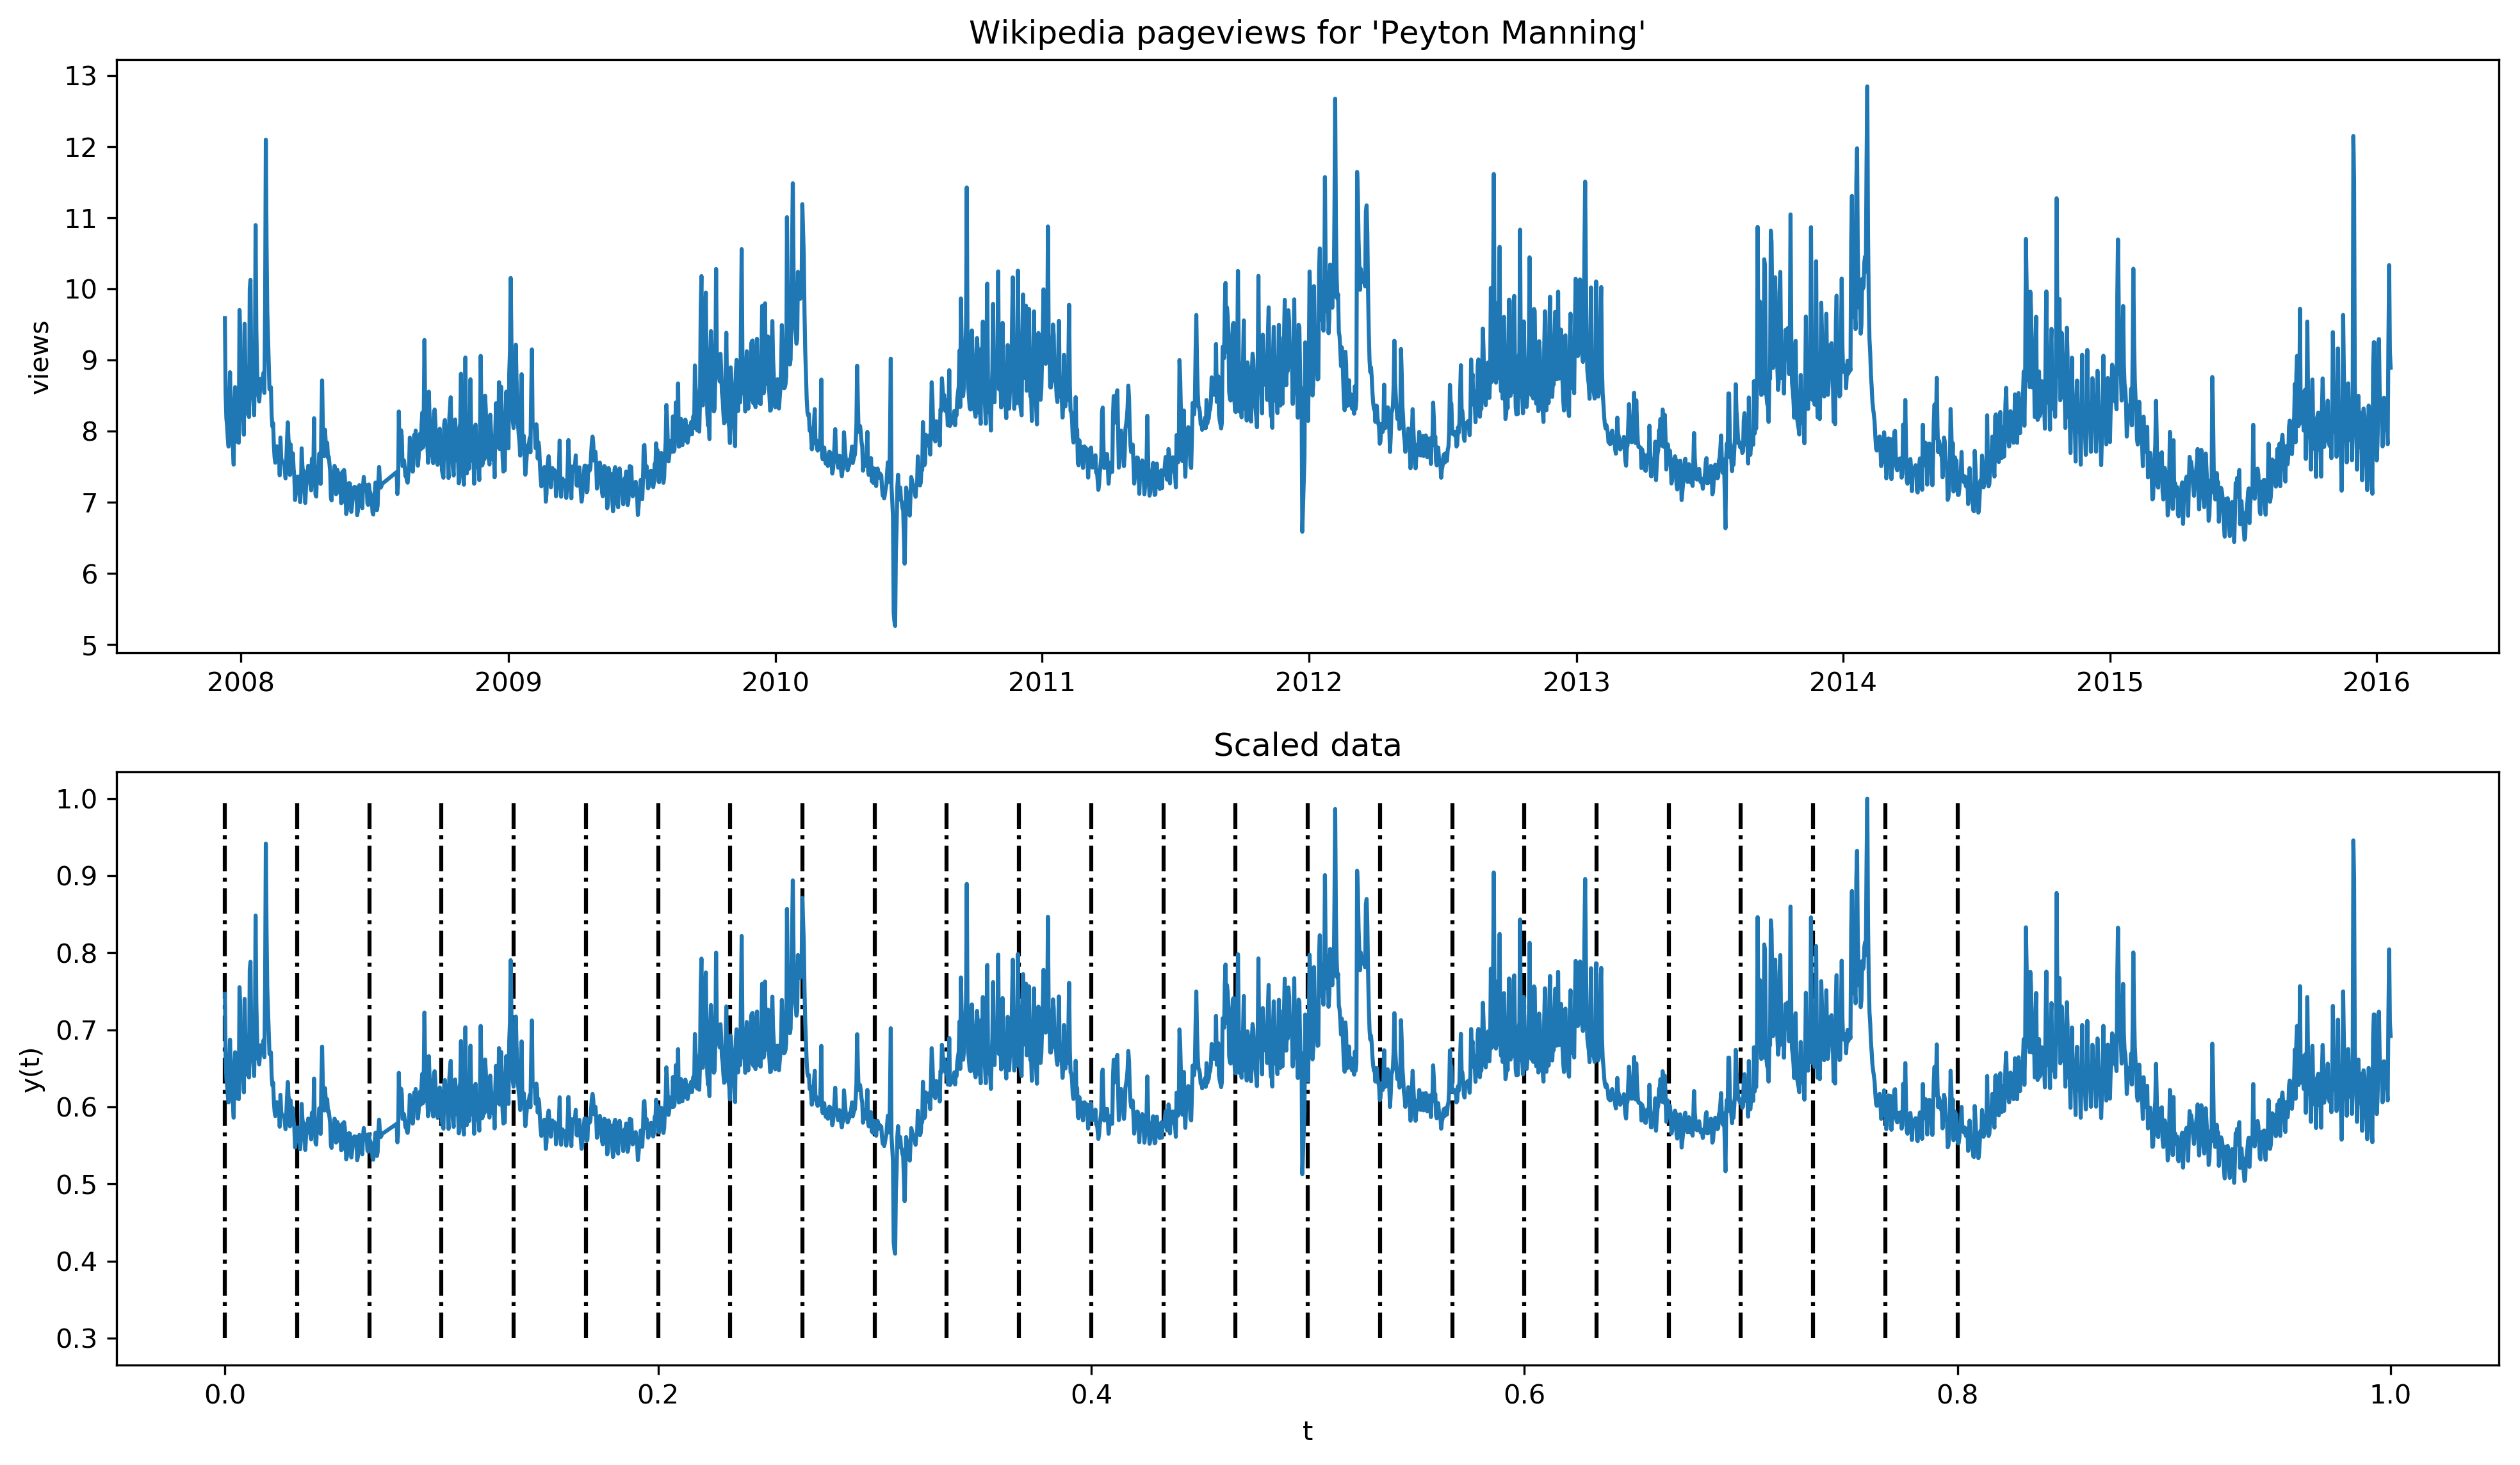

In [3]:
np.random.seed(25)

n_changepoints = 25
t = np.linspace(0, 1, 1000)

s = np.linspace(0, t[-1] * 0.8, n_changepoints)

# plt.figure(figsize=(16, 3))
# plt.xlabel('t')
# plt.yticks([])


fig = plt.figure(figsize=(16, 9), dpi=300)
fig.patch.set_facecolor('white')
plt.subplot(211)

plt.title("Wikipedia pageviews for 'Peyton Manning'")
plt.ylabel('views')
plt.plot(df['ds'], df['y'])

plt.subplot(212)
plt.title('Scaled data')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.plot(df['t'], df['y_scaled'])
plt.vlines(s, 0.3, df['t'].max(), linestyle='-.')

In [4]:
def det_dot(a, b):
    """
    The theano dot product and NUTS sampler don't work with large matrices?
    
    :param a: (np matrix)
    :param b: (theano vector)
    """
    return (a * b[None, :]).sum(axis=-1)

def trend_model(m, t, n_changepoints=25, changepoints_prior_scale=0.05, 
                growth_prior_scale=5, changepoint_range=0.8):
    """
    The piecewise linear trend with changepoint implementation in PyMC3.
    :param m: (pm.Model)
    :param t: (np.array) MinMax scaled time.
    :param n_changepoints: (int) The number of changepoints to model.
    :param changepoint_prior_scale: (flt/ None) The scale of the Laplace prior on the delta vector.
                                    If None, a hierarchical prior is set.
    :param growth_prior_scale: (flt) The standard deviation of the prior on the growth.
    :param changepoint_range: (flt) Proportion of history in which trend changepoints will be estimated. 
    :return g, A, s: (tt.vector, np.array, tt.vector)
    """
    s = np.linspace(0, changepoint_range * np.max(t), n_changepoints + 1)[1:]
    
    # * 1 casts the boolean to integers
    A = (t[:, None] > s) * 1

    with m:
        # initial growth
        k = pm.Normal('k', 0 , growth_prior_scale)
        
        if changepoints_prior_scale is None:
            changepoints_prior_scale = pm.Exponential('tau', 1.5)
        
        # rate of change
        delta = pm.Laplace('delta', 0, changepoints_prior_scale, shape=n_changepoints)
        # offset
        m = pm.Normal('m', 0, 5)
        gamma = -s * delta
        
        g = (k + det_dot(A, delta)) * t + (m + det_dot(A, gamma))
    return g, A, s



with pm.Model() as m:
    y, A, s = trend_model(m, df['t'])
    
    sigma = pm.HalfCauchy('sigma', 0.5, testval=1)
    pm.Normal('obs', 
                 mu=y,
                 sd=sigma,
                 observed=df['y_scaled'])
    aprox_1 = pm.find_MAP()
    

with pm.Model() as m:
    y, A, s = trend_model(m, df['t'], changepoints_prior_scale=0.5)
    
    sigma = pm.HalfCauchy('sigma', 0.5, testval=1)
    pm.Normal('obs', 
                 mu=y,
                 sd=sigma,
                 observed=df['y_scaled'])
    aprox_2 = pm.find_MAP()



logp = 4,021.6, ||grad|| = 139.89: 100%|██████████| 253/253 [00:00<00:00, 757.38it/s] 
logp = 4,507.7, ||grad|| = 3.9738: 100%|██████████| 1230/1230 [00:01<00:00, 759.43it/s]


([], <a list of 0 Text yticklabel objects>)

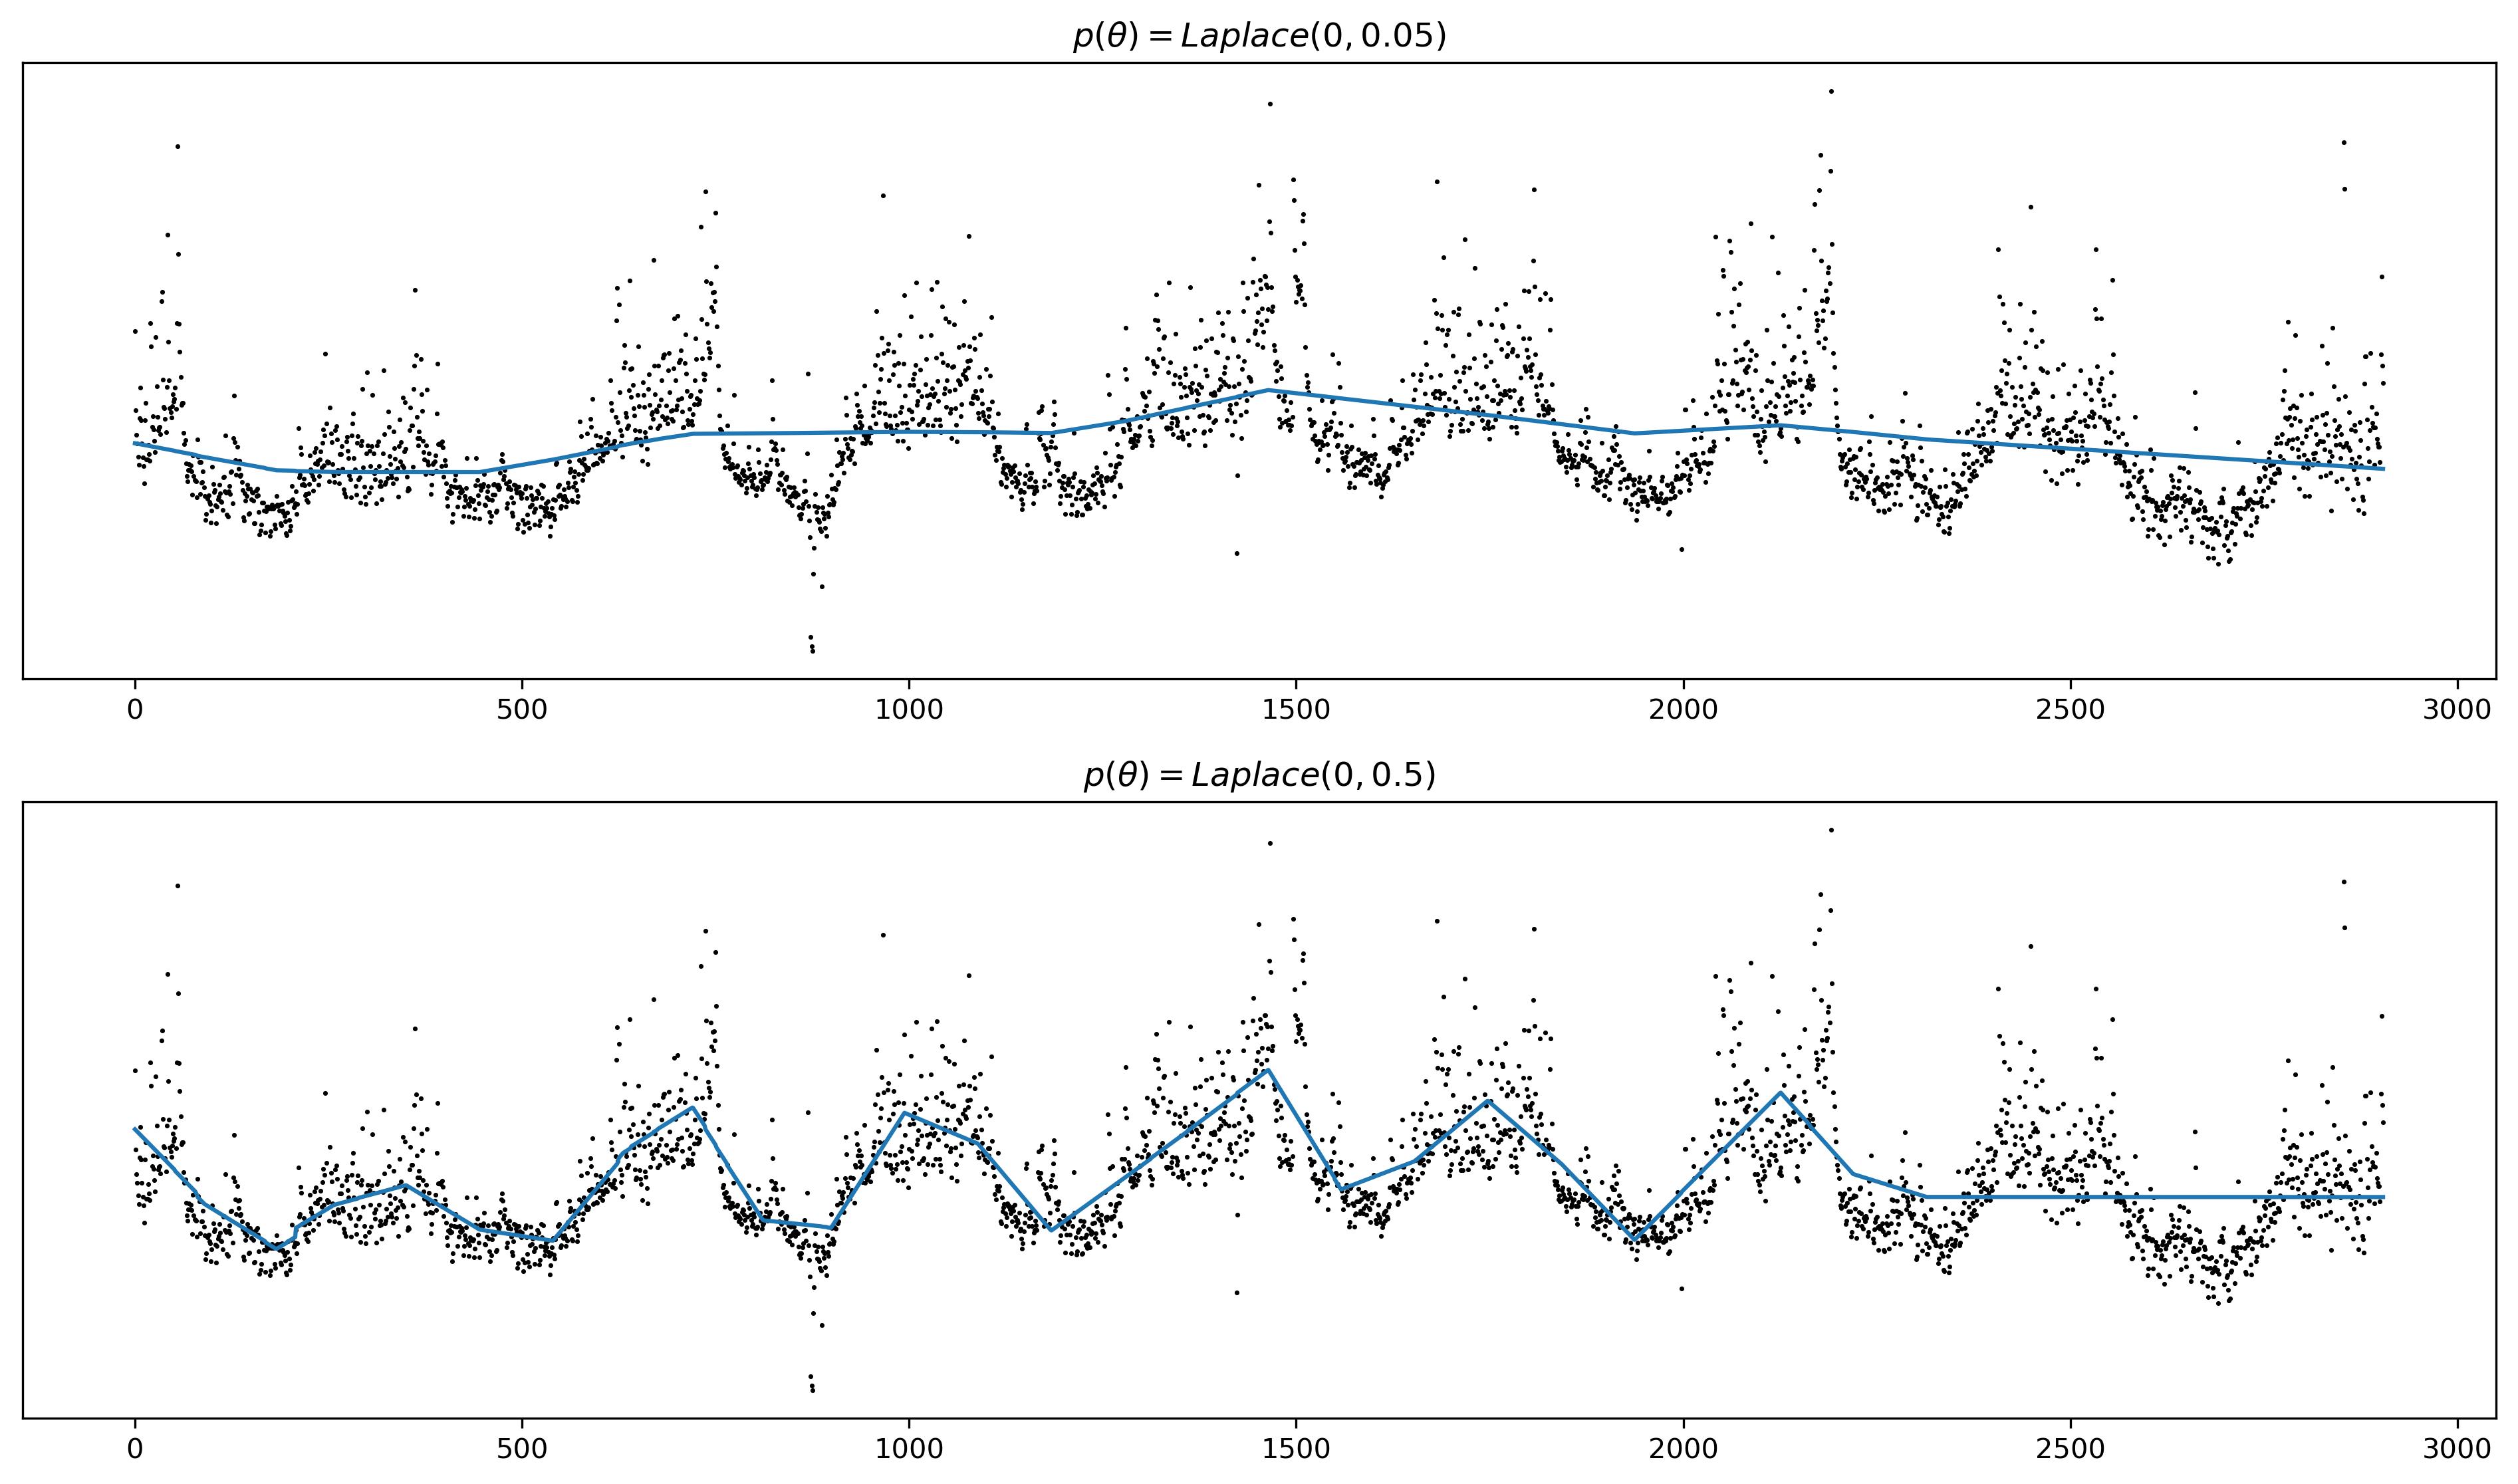

In [5]:
# Determine g, based on the parameters
def det_trend(k, m, delta, t, s, A):
    return (k + np.dot(A, delta)) * t + (m + np.dot(A, (-s * delta)))

# run function and rescale to original scale
g_1 = det_trend(aprox_1['k'], aprox_1['m'], aprox_1['delta'], df['t'], s, A) * df['y'].max()
g_2 = det_trend(aprox_2['k'], aprox_2['m'], aprox_2['delta'], df['t'], s, A) * df['y'].max()

plt.figure(figsize=(16, 9), dpi=300)

plt.subplot(211)
plt.title('$p(\\theta) = Laplace(0, 0.05)$')
plt.plot(g_1)
plt.scatter(np.arange(df.shape[0]), df.y, s=0.5, color='black')
plt.yticks([])


plt.subplot(212)
plt.title('$p(\\theta) = Laplace(0, 0.5)$')
plt.plot(g_2)
plt.scatter(np.arange(df.shape[0]), df.y, s=0.5, color='black')
plt.yticks([])


Text(0.5, 1.0, 'Fourier series')

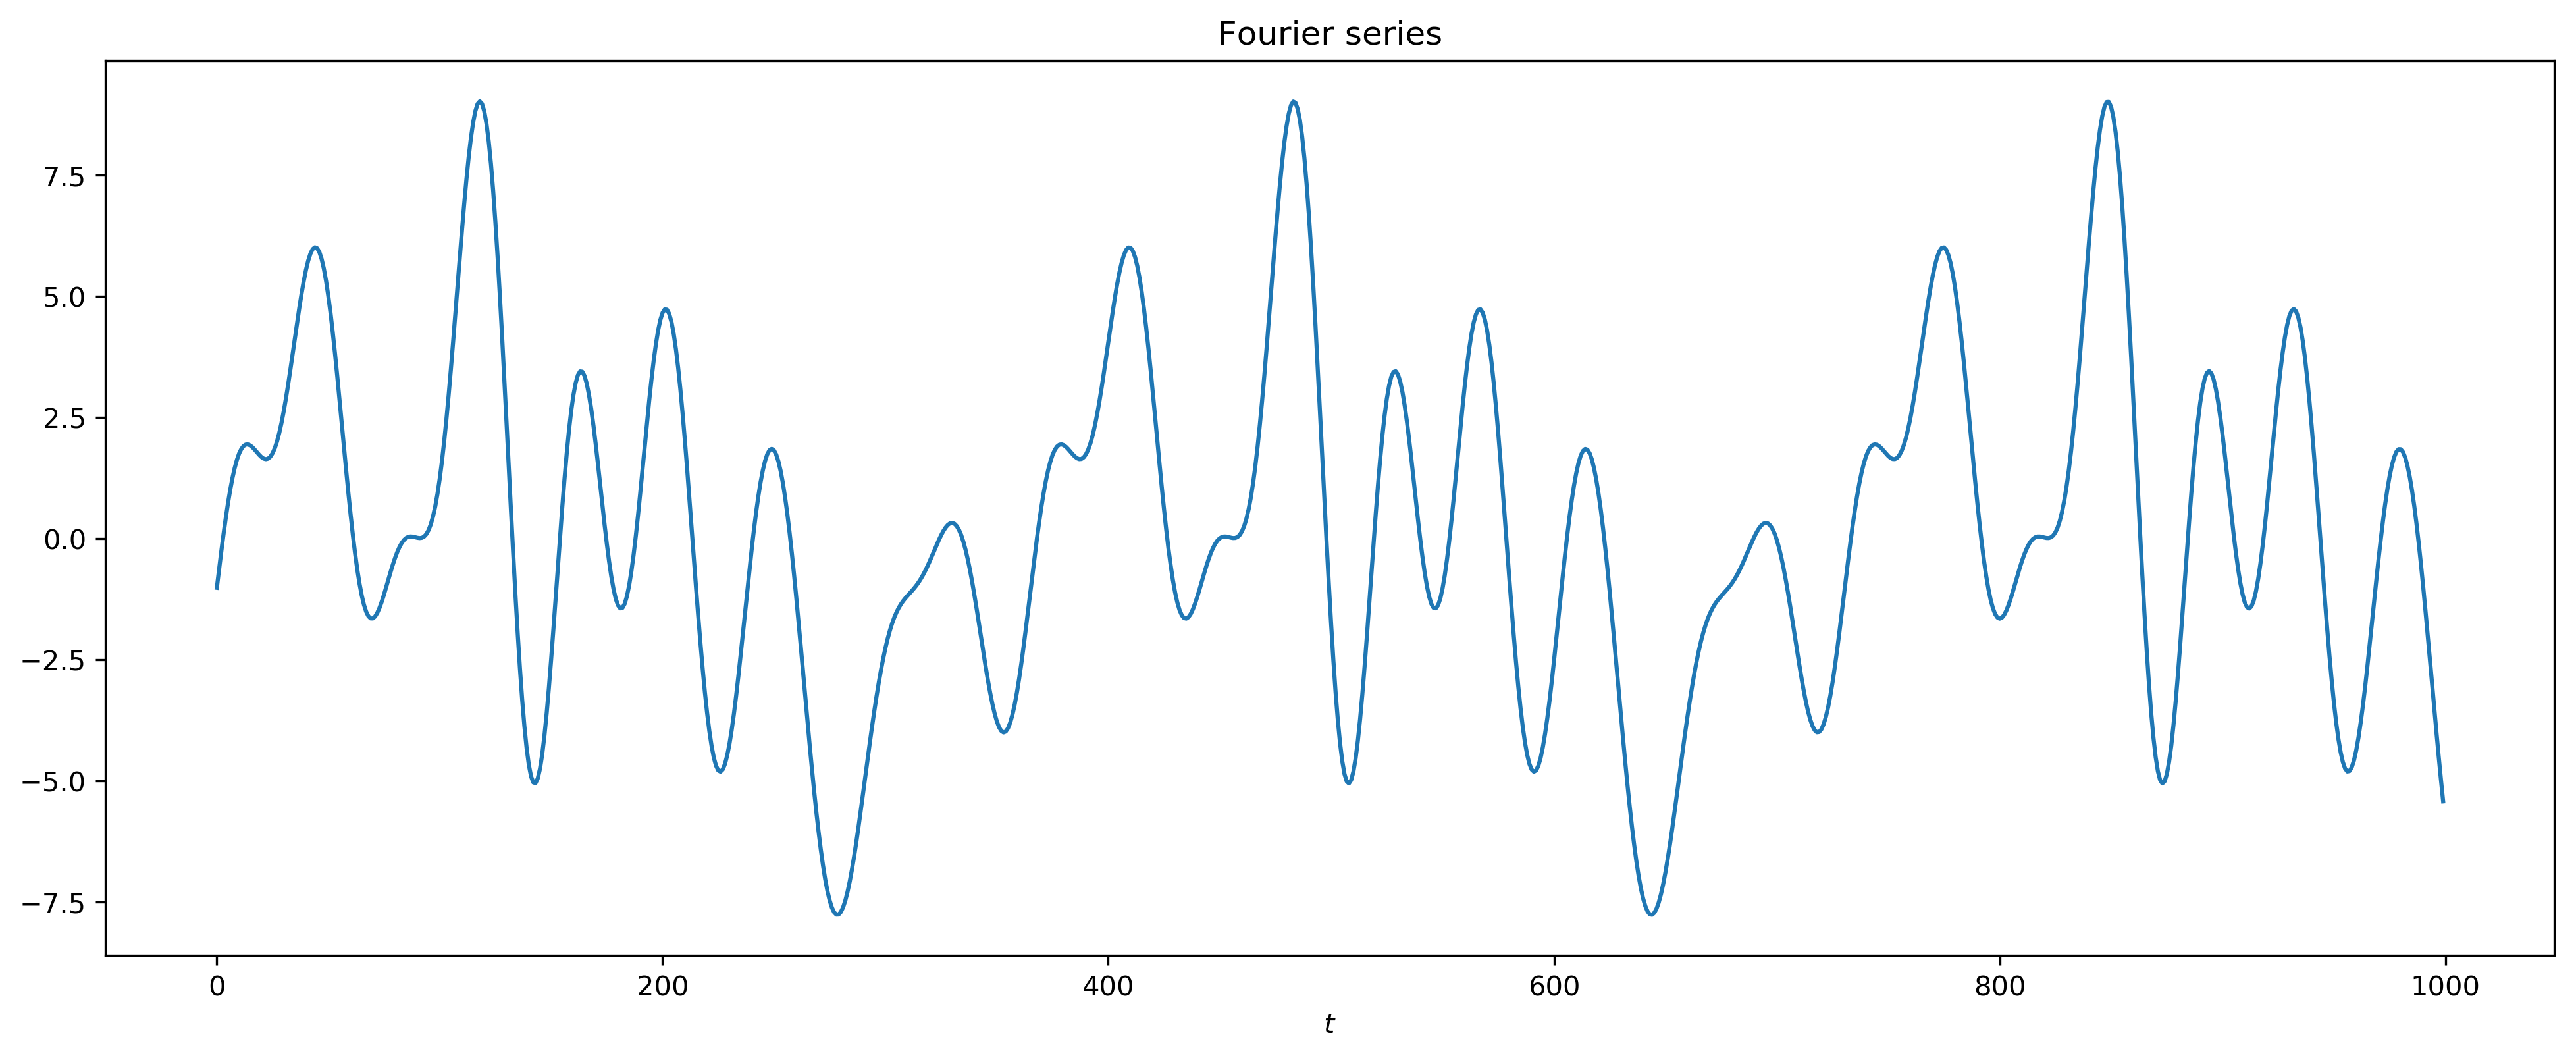

In [6]:
np.random.seed(6)
def fourier_series(t, p, n):
    # 2 pi n / p
    x = 2 * np.pi * np.arange(1, n + 1) / p
    # 2 pi n / p * t
    x = x * t[:, None]
    x = np.concatenate((np.cos(x), np.sin(x)), axis=1)
    return x

n = 10
t = np.arange(1000)
beta = np.random.normal(size=2 * n)
np.dot(fourier_series(t, 365.25, n), beta)

plt.figure(figsize=(16, 6), dpi=300)
plt.plot(np.dot(fourier_series(t, 365.25, n), beta))
plt.xlabel('$t$')
plt.title('Fourier series')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_weekly, beta_yearly, m, delta, tau, k]
Sampling 4 chains: 100%|██████████| 4000/4000 [18:43<00:00,  2.50draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/opt/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` a

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f791153bfd0>,
      dtype=object)

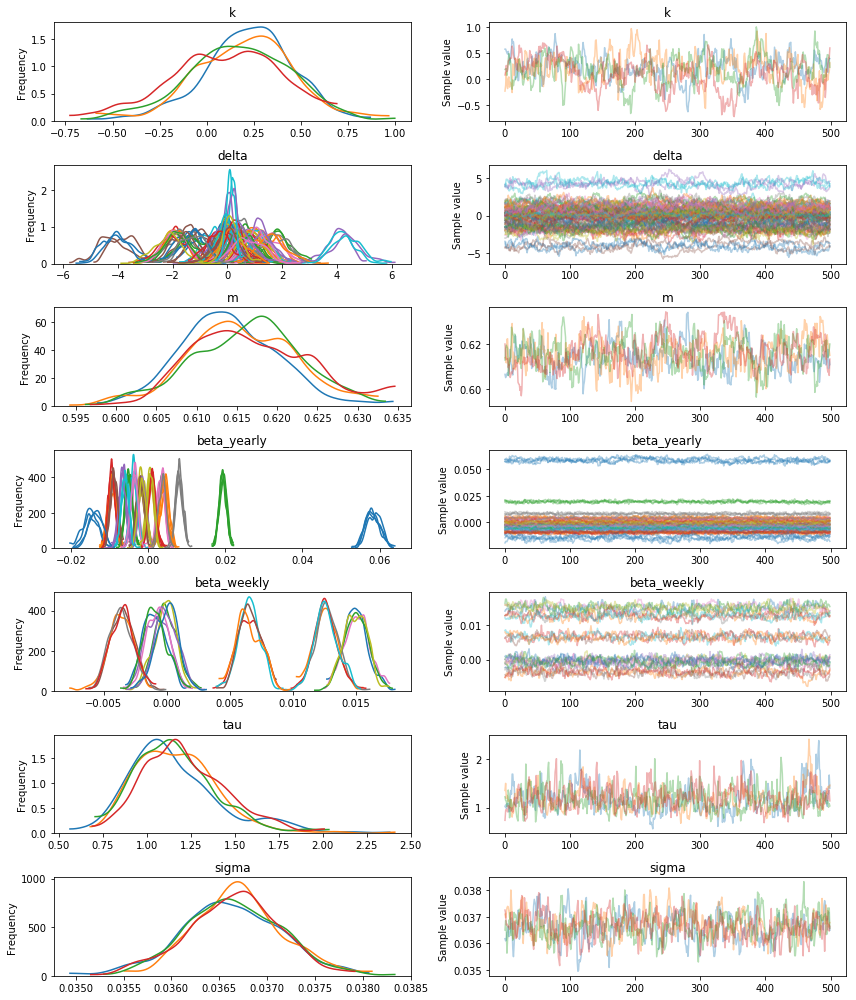

In [9]:
def seasonality_model(m, df, period='yearly', seasonality_prior_scale=10):
    
    if period == 'yearly':
        n = 10
        # rescale the period, as t is also scaled
        p = 365.25 / (df['ds'].max() - df['ds'].min()).days
    else:  # weekly
        n = 3
        # rescale the period, as t is also scaled
        p = 7 / (df['ds'].max() - df['ds'].min()).days
    x = fourier_series(df['t'], p, n)
    with m:
        beta = pm.Normal(f'beta_{period}', mu=0, sd=seasonality_prior_scale, shape=2 * n)
    return x, beta

m = pm.Model()

with m:
    # changepoints_prior_scale is None, so the exponential distribution
    # will be used as prior on \tau.
    y, A, s = trend_model(m, df['t'], changepoints_prior_scale=None)
    x_yearly, beta_yearly = seasonality_model(m, df, 'yearly')
    x_weekly, beta_weekly = seasonality_model(m, df, 'weekly')
    
    y += det_dot(x_yearly, beta_yearly) + det_dot(x_weekly, beta_weekly)
    
    sigma = pm.HalfCauchy('sigma', 0.5, testval=1)
    obs = pm.Normal('obs', 
                 mu=y, 
                 sd=sigma,
                 observed=df['y_scaled'])
with m:
    trace = pm.sample(500)
pm.traceplot(trace)

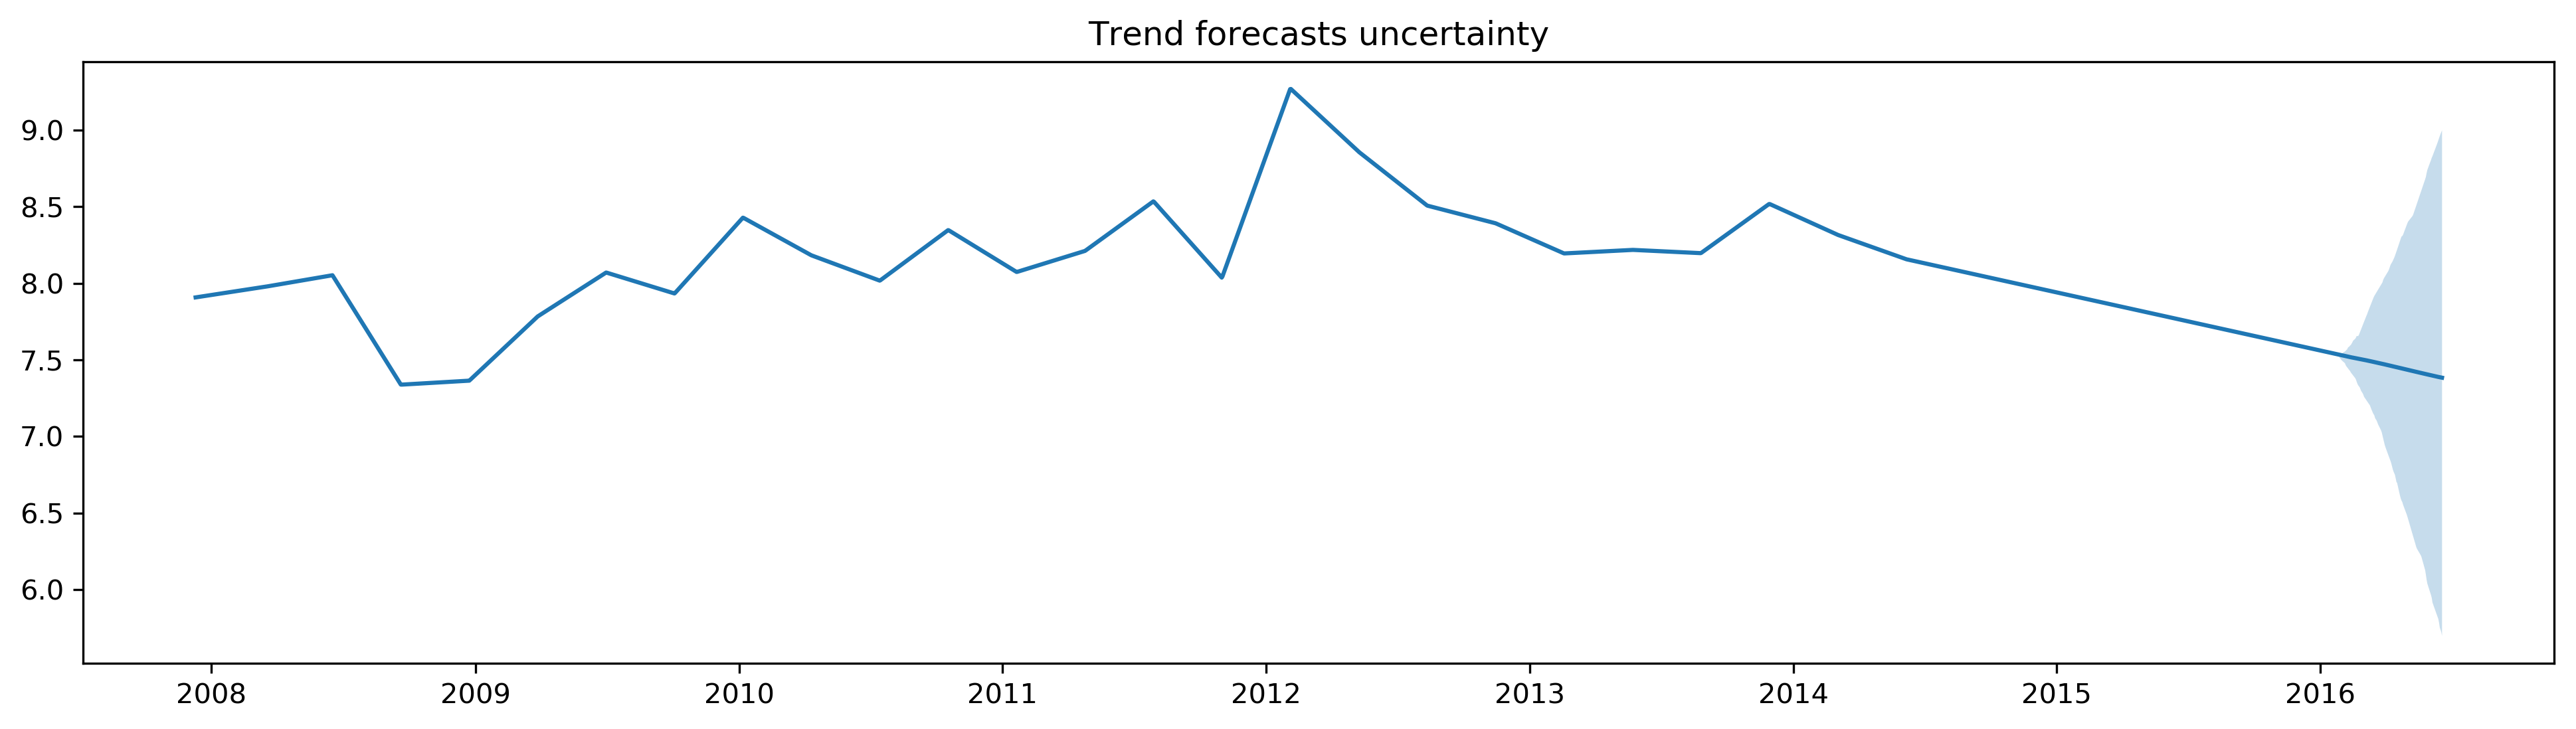

In [13]:
n_samples = 1000
days = 150
history_points = df.shape[0]
probability_changepoint = n_changepoints / history_points

future = pd.DataFrame({'ds': pd.date_range(df['ds'].min(), 
                                           df['ds'].max() + pd.Timedelta(days, 'D'), 
                        df.shape[0] + days)})
future['t'] = (future['ds'] - df['ds'].min()) / (df['ds'].max() - df['ds'].min())

# vector distributions
beta_yearly = trace['beta_yearly'].mean(0)
beta_weekly = trace['beta_weekly'].mean(0)
delta = trace['delta'].mean(0)

# scalar distributions
k = trace['k'].mean()
m = trace['m'].mean()

trend_forecast = []
lambda_ = trace['tau'].mean()

for n in range(n_samples):
    new_changepoints = future['t'][future['t'] > 1].values
    sample = np.random.random(new_changepoints.shape)
    new_changepoints = new_changepoints[sample <= probability_changepoint]
    new_delta = np.r_[delta, 
                      stats.laplace(0, lambda_).rvs(new_changepoints.shape[0])]
    new_s = np.r_[s, new_changepoints]
    new_A = (future['t'][:, None] > new_s) * 1

    trend_forecast.append(((k + np.dot(new_A, new_delta)) * future['t']  + (m + np.dot(new_A, (-new_s * new_delta)))) * df['y'].max())
    
trend_forecast = np.array(trend_forecast)

date = future['ds'].dt.to_pydatetime()
plt.figure(figsize=(16, 4), dpi=300)
plt.title('Trend forecasts uncertainty')
plt.plot(date, trend_forecast.mean(0))
quant = np.quantile(trend_forecast, [0.025, 0.975], axis=0)
plt.fill_between(date, quant[0, :], quant[1, :], alpha=0.25)
